---
# XAI-AttackBench Demo Notebook (Synthetic Data)

This notebook demonstrates the **end-to-end pipeline** on a **synthetic tabular dataset** for the Greedy Hill Climb attack:

- create a dataset with **numerical + categorical** features
- train a model
- fit an explainer (**LIME** or **SHAP Kernel**)
- run a **black-box** attack (**GreedyHillClimb**) that tries to **change explanations** while keeping predictions similar
- compare explanation vectors before/after
- visualize the attack


In [1]:
# std-lib imports
from pathlib import Path
import tempfile

# 3-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Projekt imports

# base imports
from xai_bench.datasets.base_dataset import BaseDataset
from xai_bench.base import BaseMetric

# models / explainers / attacks
from xai_bench.models.random_forest import SKRandomForest
from xai_bench.explainer.lime_explainer import LimeTabularAdapter
from xai_bench.explainer.shap_explainer import ShapAdapter
from xai_bench.attacks.greedy_hill_climb import GreedyHillClimb

# metrics
from xai_bench.metrics.l2_metric import L2Metric

---
## 0) Seed

In [2]:
seed = 3113

---
## 1) Create a synthetic dataset

We create a **tiny and interpretable** synthetic loan approval dataset with only **3 input features**:

- **numerical** (already normalized):
  - `income` (z-scored)
  - `age` (z-scored)
- **categorical**:
  - `existing_customer` with values `new` / `existing`  (converted via **one-hot encoding** into `existing_customer_existing`)

The binary target `loan_approved` is generated from a **non-linear decision rule**
(including interactions + noise), so the model behavior is realistic enough.

In [3]:
class TinySyntheticDataset(BaseDataset):
    def __init__(self, path: str, random_state: int = 42, **kwargs):
        self.categorical_features = ["existing_customer"]      
        self.numerical_features = ["income", "age"]     
        self.target = "loan_approved"
        self.task = "classification"
        super().__init__(path=path, random_state=random_state, stratify=True, **kwargs)

    def read(self) -> pd.DataFrame:
        self.df_raw = pd.read_csv(self.path)
        return self.df_raw

    def preprocess(self) -> pd.DataFrame:
        df = self.df_raw.copy()
        self.y_full = df[self.target].astype(int)

        X = df.drop(columns=[self.target]).copy()

        dummies = pd.get_dummies(X["existing_customer"], prefix="existing_customer", drop_first=True).astype(float)
        X = pd.concat([X.drop(columns=["existing_customer"]), dummies], axis=1)

        self.feature_mapping = {c: [c] for c in X.columns}
        self.X_full = X.astype(float)
        return self.X_full


def make_tiny_df(n=2000, seed=42):
    rng = np.random.default_rng(seed)

    income = np.clip(rng.normal(60, 20, size=n), 10, 150)   # k$
    age = rng.integers(18, 70, size=n)

    existing_customer = rng.choice(["new", "existing"], size=n, p=[0.5, 0.5])

    income = (income - income.mean()) / (income.std() + 1e-8)
    age = (age - age.mean()) / (age.std() + 1e-8)

    group = np.where(existing_customer == "existing", 1.0, -1.0)

    # target rule
    logit = (
        1.2 * income
        + 0.6 * np.tanh(age)
        + 0.7 * group
        - 0.8 * income * np.tanh(age)
        + 0.25 * rng.normal(0, 1, size=n)
    )
    p = 1 / (1 + np.exp(-logit))
    y = (p > 0.5).astype(int)

    return pd.DataFrame({
        "income": income.astype(float),
        "age": age.astype(float),
        "existing_customer": existing_customer,
        "loan_approved": y
    })


tmp = tempfile.TemporaryDirectory()
csv_path = Path(tmp.name) / "tiny_synth.csv"
df = make_tiny_df(n=2000, seed=42)
df.to_csv(csv_path, index=False)

dataset = TinySyntheticDataset(path=str(csv_path), test_size=0.2, random_state=42)

print("X_train_scaled shape:", dataset.X_train_scaled.shape)
print("Features:", dataset.features.feature_names_model)  # should be: income, age, existing_customer_existing

X_train_scaled shape: (1600, 3)
Features: ['income', 'age', 'existing_customer_new']


### 1.1) Visualize Dataset

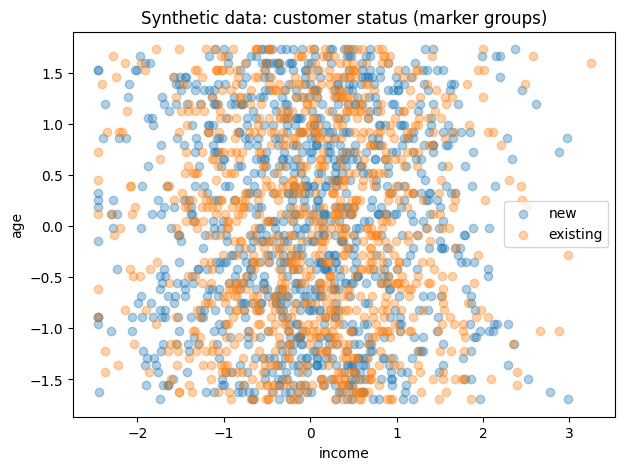

In [4]:
dfp = df.copy()
dfp["existing_customer_dummy"] = (dfp["existing_customer"] == "existing").astype(int)

plt.figure(figsize=(7,5))
m0 = dfp["existing_customer_dummy"] == 0
m1 = ~m0
plt.scatter(dfp.loc[m0,"income"], dfp.loc[m0,"age"], alpha=0.35, label="new")
plt.scatter(dfp.loc[m1,"income"], dfp.loc[m1,"age"], alpha=0.35, label="existing")
plt.title("Synthetic data: customer status (marker groups)")
plt.xlabel("income")
plt.ylabel("age")
plt.legend()
plt.show()

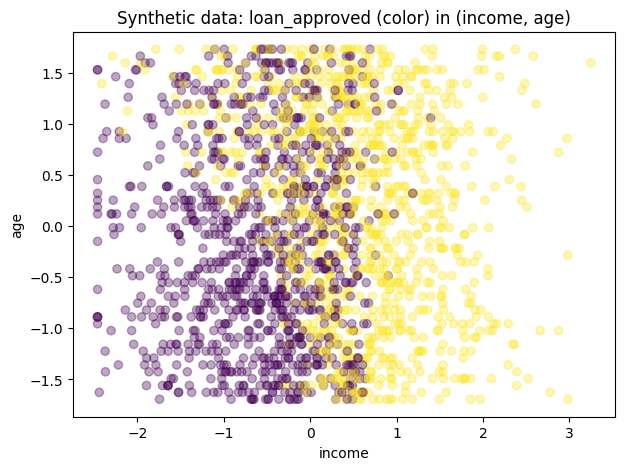

In [5]:
plt.figure(figsize=(7,5))
plt.scatter(dfp["income"], dfp["age"], c=dfp["loan_approved"], alpha=0.35)
plt.title("Synthetic data: loan_approved (color) in (income, age)")
plt.xlabel("income")
plt.ylabel("age")
plt.show()

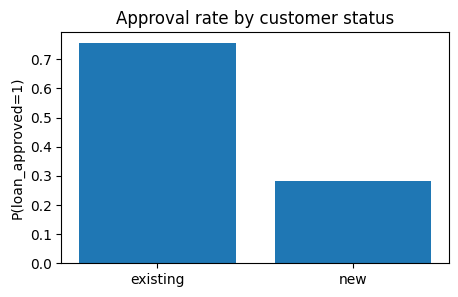

In [6]:
rates = dfp.groupby("existing_customer")["loan_approved"].mean()
plt.figure(figsize=(5,3))
plt.bar(rates.index.astype(str), rates.values)
plt.title("Approval rate by customer status")
plt.ylabel("P(loan_approved=1)")
plt.show()

---
## 2) Train a model (Random Forest)

We use the repo's `SKRandomForest` model wrapper (black-box access via `predict`/`predict_proba`).


In [7]:
model = SKRandomForest(
    task=dataset.task,
    n_estimators=100,
    random_state=seed,
    max_depth=12
)

Xtr = dataset.X_train_scaled.values
ytr = dataset.y_train.values
Xte = dataset.X_test_scaled.values
yte = dataset.y_test.values

model.fit(Xtr, ytr)
acc = accuracy_score(yte, model.predict(Xte))
print("Test accuracy:", acc)


Test accuracy: 0.9125


---
## 3) Fit explainers

In [8]:
EXPLAINER = "lime"  # "shap"

if EXPLAINER == "lime":
    explainer = LimeTabularAdapter(dataset=dataset, num_samples=150, random_state=seed)
elif EXPLAINER == "shap":
    explainer = ShapAdapter(dataset=dataset, nsamples=75, background_size=50, random_state=seed)
else:
    raise ValueError("EXPLAINER must be 'lime' or 'shap'")

explainer.fit(dataset.X_train_scaled.values, model, dataset.features)
print("Explainer fitted:", explainer.__class__.__name__)

Explainer fitted: LimeTabularAdapter


---
## 4) Run a black-box explanation attack (GreedyHillClimb)

Goal: find `x_adv` close to `x` (bounded by `epsilon` in prediction distance) but with maximally changed explanations.

We keep parameters small for a notebook run.


In [9]:
metric: BaseMetric = L2Metric()  # explanation drift metric used by the attack

attack = GreedyHillClimb(
    dataset=dataset,
    model=model,
    explainer=explainer,
    metric=metric,
    epsilon=0.05,
    num_climbs=20,
    num_derections=15,
    max_trys=1,
    step_len=0.0005,
    proba_numeric=0.8,
    seed=seed,
    num_samples_explainer= 30,
    task=dataset.task
)

---
## 5) Attack a few samples and compare explanations

We attack a small batch to keep runtime reasonable.


In [ ]:
num_smaples = 1

# pick num_sampples samples
rng = np.random.default_rng(seed)
idx = rng.choice(len(Xte), size=num_smaples, replace=False)

X_example = Xte[idx]
y_example = yte[idx]

# generate adversarial samples (black-box)
X_adv = attack.generate(X_example)

# predictions
pred = model.predict(X_example)
pred_adv = model.predict(X_adv)

# fidelity (how often prediction stayed the same)
fidelity = (pred == pred_adv).mean()
print("Prediction fidelity:", fidelity)

# explanations
E = explainer.explain(X_example)
E_adv = explainer.explain(X_adv)

# explanation drift score (CosineMetric returns per-sample array)
drift = metric.compute(E, E_adv)
drift = np.asarray(drift).reshape(-1)
print(f"L2 Metric over the {1} (Higher = better):", drift)
print("Mean L2:", drift.mean())

Output()

Prediction fidelity: 1.0
L2 Metric over the 1 (Lower = more similar): [1.95798429]
Mean L2: 1.9579842923587483


---
## 6) Visualize explanation vectors (before vs after)

Show the difference of the real instance and the attacked instance

In [11]:
feature_names = np.array(dataset.features.feature_names_model)

x_real = X_example[-1]
x_adv  = X_adv[-1]

print("=== REAL instance ===")
for f, v in zip(feature_names, x_real):
    print(f"{f:25s}: {v:.4f}")

print("\n=== ADV instance ===")
for f, v in zip(feature_names, x_adv):
    print(f"{f:25s}: {v:.4f}")

=== REAL instance ===
income                   : 0.7243
age                      : 1.3377
existing_customer_new    : 0.0000

=== ADV instance ===
income                   : 0.7270
age                      : 1.3368
existing_customer_new    : 0.0000


Plot the explanation vector for one sample before/after attack.

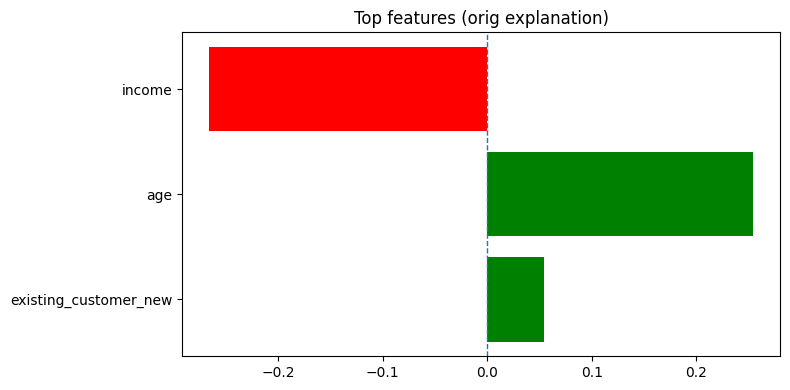

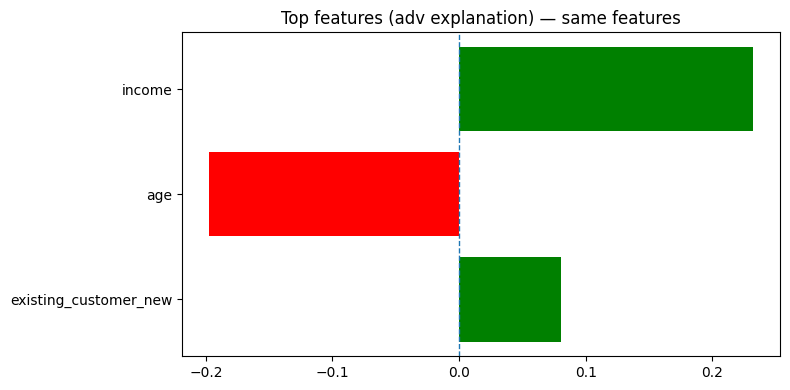

In [12]:
explanation_real = E[-1].ravel()
explanation_attacked = E_adv[-1].ravel()

def sign_colors(vals):
    return ["green" if v >= 0 else "red" for v in vals]

# Orginal top features
top = np.argsort(np.abs(explanation_real))[-12:][::-1]
vals0 = explanation_real[top][::-1]
names = feature_names[top][::-1]

plt.figure(figsize=(8,4))
plt.barh(names, vals0, color=sign_colors(vals0))
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top features (orig explanation)")
plt.tight_layout()
plt.show()


# attacked top features
vals1 = explanation_attacked[top][::-1]

plt.figure(figsize=(8,4))
plt.barh(names, vals1, color=sign_colors(vals1))
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top features (adv explanation) — same features")
plt.tight_layout()
plt.show()

---
## 7) Visualize the GreedyHillClimb search

### 7.1) Run trace on a single sample


In [13]:
x0 = X_example[-1].copy()

x_adv_trace, trace = attack._trace_generate(x0, num_directions=20, max_steps=20)

cols = list(dataset.features.feature_names_model)
ix_income = cols.index("income")
ix_age    = cols.index("age")

dummy_cols = [c for c in cols if c.startswith("existing_customer_")]
ix_exist = cols.index(dummy_cols[0])

path = np.asarray(trace["path"])
cand_all = np.vstack([np.asarray(C) for C in trace["cand_x"]])
scores = np.concatenate([np.asarray(s).reshape(-1) for s in trace["cand_scores"]])  

print("Steps recorded:", len(trace["path"]) - 1)
print("Pred Class bevor Attack:", model.predict(x0.reshape(1,-1))[0], " Pred Class avter Attack:", model.predict(x_adv_trace.reshape(1,-1))[0])

[WARNING] THIS FUNKTION IS ONLY FOR VISUALISATION
Steps recorded: 20
Pred Class bevor Attack: 1  Pred Class avter Attack: 1


### 7.2) Features bevore vs. avter the attack

In [14]:
print("==== REAL instance ==========================")
for f, v in zip(feature_names, x0):
    print(f"{f:25s}: {v:.4f}")

print("\n\n=== Attacked instance ===========================")
for f, v in zip(feature_names, x_adv_trace):
    print(f"{f:25s}: {v:.4f}")

==== REAL instance ==========================
income                   : 0.7243
age                      : 1.3377
existing_customer_new    : 0.0000


=== Attacked instance ===========================
income                   : 0.7156
age                      : 1.3440
existing_customer_new    : 0.0000


### 7.3) Visualize candidates + chosen move for the first step

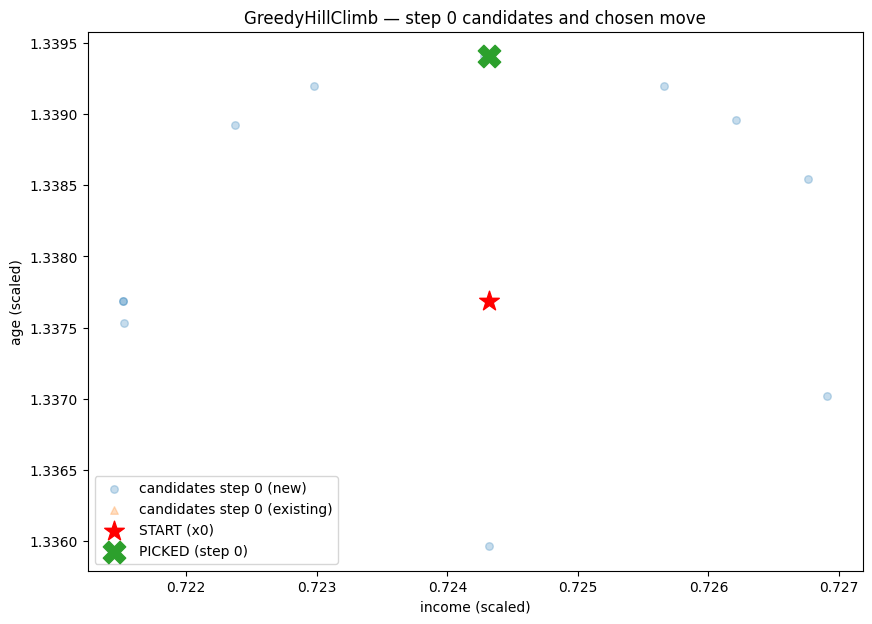

In [15]:
C0 = np.asarray(trace["cand_x"][0])
j0 = int(trace["picked_idx"][0])
x0 = path[0]

m_new = C0[:, ix_exist] < 0.5
m_old = ~m_new

plt.figure(figsize=(10,7))
plt.scatter(C0[m_new, ix_income], C0[m_new, ix_age], alpha=0.25, s=30, marker="o", label="candidates step 0 (new)")
plt.scatter(C0[m_old, ix_income], C0[m_old, ix_age], alpha=0.25, s=30, marker="^", label="candidates step 0 (existing)")
plt.scatter(x0[ix_income], x0[ix_age], s=220, marker="*", color="red",  zorder=1000,  label="START (x0)")

if 0 <= j0 < len(C0):
    plt.scatter(C0[j0, ix_income], C0[j0, ix_age], s=260, marker="X", label="PICKED (step 0)")

plt.title("GreedyHillClimb — step 0 candidates and chosen move")
plt.xlabel("income (scaled)")
plt.ylabel("age (scaled)")
plt.legend()
plt.show()

### 7.4) Visualize candidates + chosen path for all steps

#### By Class

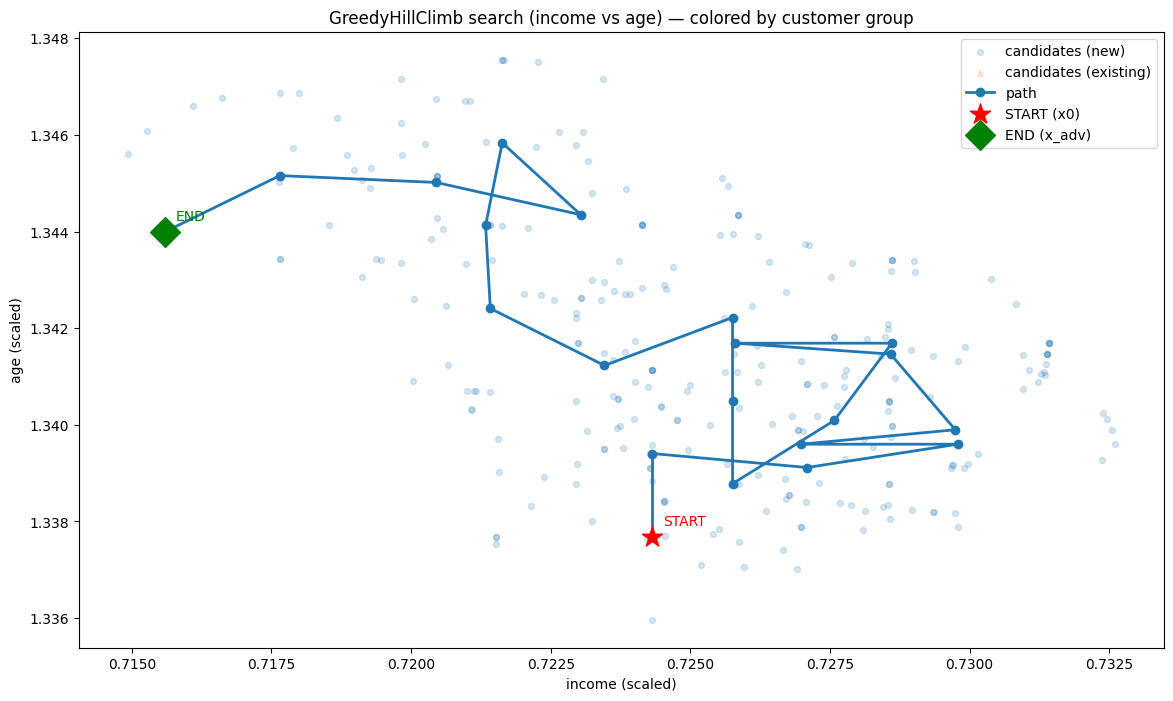

In [16]:
m_new = cand_all[:, ix_exist] < 0.5
m_old = ~m_new

plt.figure(figsize=(14,8))

plt.scatter(cand_all[m_new, ix_income], cand_all[m_new, ix_age],
            alpha=0.18, s=18, marker="o", label="candidates (new)")
plt.scatter(cand_all[m_old, ix_income], cand_all[m_old, ix_age],
            alpha=0.18, s=18, marker="^", label="candidates (existing)")

plt.plot(path[:, ix_income], path[:, ix_age], marker="o", linewidth=2, label="path")

plt.scatter(path[0, ix_income],  path[0, ix_age],  s=230, marker="*", color="red", zorder=1000, label="START (x0)")
plt.scatter(path[-1, ix_income], path[-1, ix_age], s=230, marker="D", color="green", zorder=1000, label="END (x_adv)")

plt.annotate("START", (path[0, ix_income], path[0, ix_age]), color="red", zorder=1000, textcoords="offset points", xytext=(8,8))
plt.annotate("END",   (path[-1, ix_income], path[-1, ix_age]), color="green", zorder=1000, textcoords="offset points", xytext=(8,8))

plt.title("GreedyHillClimb search (income vs age) — colored by customer group")
plt.xlabel("income (scaled)")
plt.ylabel("age (scaled)")
plt.legend()
plt.show()



#### By Metric Score

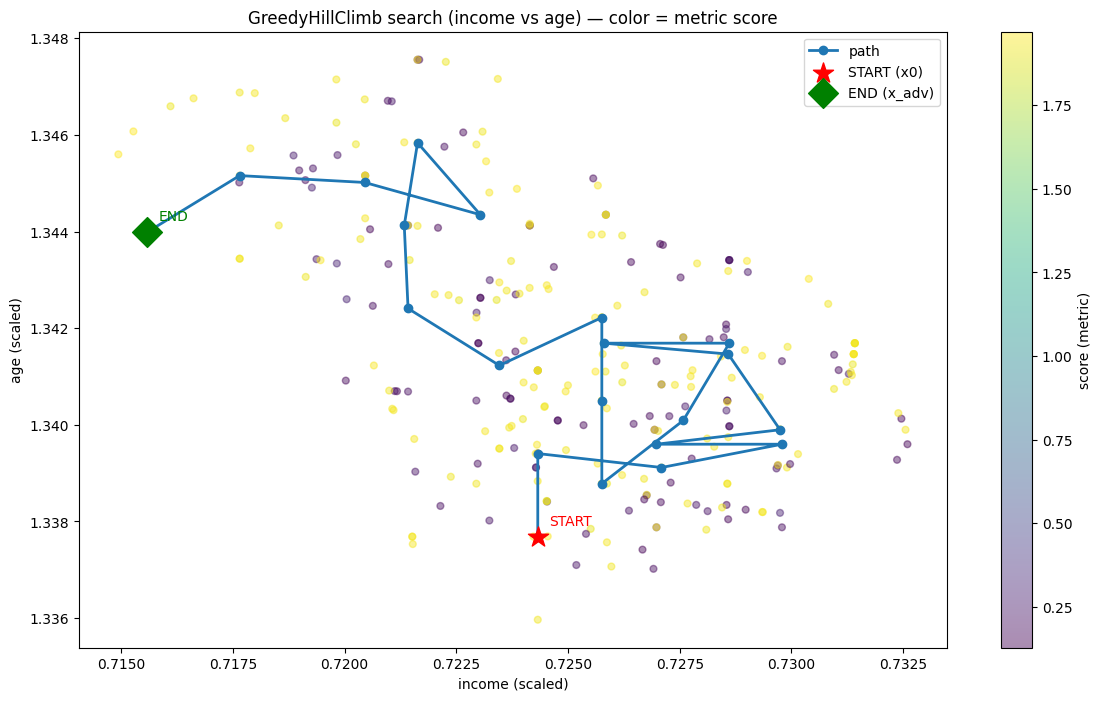

In [17]:
lo, hi = np.percentile(scores, [2, 98])
scores_c = np.clip(scores, lo, hi)

plt.figure(figsize=(14,8))

sc = plt.scatter(cand_all[:, ix_income], cand_all[:, ix_age],c=scores_c, cmap="viridis", alpha=0.45, s=24)
plt.plot(path[:, ix_income], path[:, ix_age], marker="o", linewidth=2, label="path")
plt.scatter(path[0, ix_income],  path[0, ix_age],  s=230, marker="*", zorder=1000,color="red", label="START (x0)")
plt.scatter(path[-1, ix_income], path[-1, ix_age], s=230, marker="D", zorder=1000, color="green", label="END (x_adv)")

plt.annotate("START", (path[0, ix_income], path[0, ix_age]), color="red", zorder=1000, textcoords="offset points", xytext=(8,8))
plt.annotate("END",   (path[-1, ix_income], path[-1, ix_age]), color="green", zorder=1000, textcoords="offset points", xytext=(8,8))


plt.title("GreedyHillClimb search (income vs age) — color = metric score")
plt.xlabel("income (scaled)")
plt.ylabel("age (scaled)")
plt.legend()

cbar = plt.colorbar(sc)
cbar.set_label("score (metric)")

plt.show()

### 7.5 Show which features changed per step (top-5 deltas)

In [18]:
cols = list(dataset.features.feature_names_model)
path = trace["path"]
deltas = path[1:] - path[:-1]

for t in range(deltas.shape[0]):
    d = deltas[t]
    top = np.argsort(np.abs(d))[-5:][::-1]
    print(f"\nstep {t} -> {t+1}:")
    for j in top:
        if d[j] != 0:
            print(f"  {cols[j]:<12} delta={d[j]: .4f}  new={path[t+1, j]: .4f}")



step 0 -> 1:
  age          delta= 0.0017  new= 1.3394

step 1 -> 2:
  income       delta= 0.0028  new= 0.7271
  age          delta=-0.0003  new= 1.3391

step 2 -> 3:
  income       delta= 0.0027  new= 0.7298
  age          delta= 0.0005  new= 1.3396

step 3 -> 4:
  income       delta=-0.0028  new= 0.7270

step 4 -> 5:
  income       delta= 0.0028  new= 0.7297
  age          delta= 0.0003  new= 1.3399

step 5 -> 6:
  age          delta= 0.0016  new= 1.3415
  income       delta=-0.0012  new= 0.7286

step 6 -> 7:
  income       delta=-0.0028  new= 0.7258
  age          delta= 0.0002  new= 1.3417

step 7 -> 8:
  income       delta= 0.0028  new= 0.7286

step 8 -> 9:
  age          delta=-0.0016  new= 1.3401
  income       delta=-0.0010  new= 0.7276

step 9 -> 10:
  income       delta=-0.0018  new= 0.7258
  age          delta=-0.0013  new= 1.3388

step 10 -> 11:
  age          delta= 0.0017  new= 1.3405

step 11 -> 12:
  age          delta= 0.0017  new= 1.3422

step 12 -> 13:
  income     

---
---